# Vehicle Detection


---

## The Goals

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time
import glob
import cv2
import os
from os.path import isfile
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from moviepy.editor import VideoFileClip
import copy
from IPython.display import HTML
from collections import deque

%matplotlib inline

print("End of Cell")

End of Cell


In [2]:
def extract_hog(imgs, orient=9, pix_per_cell=8, cell_per_block=2):
    
    features = []
    
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        
        img_features = []
        
        # convert image from RGB to YCrCb
        feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(hog(feature_image[:,:,channel], orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=True, 
                   visualise=False, feature_vector=True))

        img_features.append(hog_features)

        final_features = np.concatenate(img_features)
            
        features.append(final_features.tolist())

    return features
    

def scan_windows(img, windows, clf, scaler, orient=9, pix_per_cell=8, cell_per_block=2):

    on_windows = []
    
    for window in windows:
        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        img_features = []
    
        feature_image = cv2.cvtColor(test_img, cv2.COLOR_RGB2YCrCb)

        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(hog(feature_image[:,:,channel], orientations=orient, 
                   pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), 
                   transform_sqrt=True, 
                   visualise=False, feature_vector=True))

        img_features.append(hog_features)
        features = img_features
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = clf.predict(test_features)
        
        if prediction == 1:
            on_windows.append(window)
    
    return on_windows

# slide the input window in the given image and return the co-ordinates of the windows
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(150, 64), xy_overlap=(0.8, 0.8)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Draw input windows in the input image
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], (100,100,100), thick)
    
    # colorize the first 3 boxes to display the size and extent of overlapping
    ctr = 0
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates      
        if ctr % 3 == 0:
            cv2.rectangle(imcopy, bbox[0], bbox[1], (0,0,255), thick)
        elif ctr % 3 == 1:
            cv2.rectangle(imcopy, bbox[0], bbox[1], (0,255,0), thick)
        else:
            cv2.rectangle(imcopy, bbox[0], bbox[1], (255,0,0), thick)
        ctr += 1 
        
        if ctr == 3:
            break
    
    # return the image with all windows (3 colorized) drawn
    return imcopy

print("End of Cell")

End of Cell


In [3]:
# add heat map to the list of input bounding boxes
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return the heatmap
    return heatmap

# apply threshold on the heat map to remove false positives
def threshold(heatmap, threshold):
    cp_heatmap = copy.deepcopy(heatmap)
    # Zero out pixels below the threshold
    cp_heatmap[cp_heatmap <= threshold] = 0
    # Return thresholded map
    return cp_heatmap

# draw annotated boxes based on the threholded heatmaps
def draw_annotated_boxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

print("End of Cell")

End of Cell


In [4]:
# obtain all windows slid across an image and extract only those windows within which vehicles are found
def detect_vehicles(img):
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255
    
    # obtain windows of 3 different sizes and overlapping parameters 
    
    y_start_stop = [395, 650] # Min and max in y to search in slide_window()
    windows_1 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 96), xy_overlap=(0.5, 0.5))

    y_start_stop = [395, 650] # Min and max in y to search in slide_window()
    windows_2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    y_start_stop = [395, 550] # Min and max in y to search in slide_window()
    windows_3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(48, 48), xy_overlap=(0.45, 0.45))
    
    # append all 3 windows to one array of windows
    windows = windows_1 + windows_2 + windows_3
    
    # identify all windows with cars inside them
    windows_with_cars = scan_windows(image, windows, svc, X_scaler, orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)                       
    
    # draw the windows identified above on top of the given image
    img_with_windows = draw_boxes(draw_image, windows_with_cars, color=(0, 0, 255), thick = 5)                    
    return img_with_windows, windows_with_cars, windows_1, windows_2, windows_3

print("End of Cell")

End of Cell


In [5]:
def read_training_data():
    vehicle_images = glob.glob('./vehicles/vehicles/*/*.png')
    non_vehicle_images = glob.glob('./non-vehicles/non-vehicles/*/*.png')
    return (vehicle_images, non_vehicle_images)

cars, notcars = read_training_data()

print("Number of car images: ", len(cars))
print("Number of non-car images: ", len(notcars))

print("End of Cell")

Number of car images:  8792
Number of non-car images:  8968
End of Cell


End of Cell


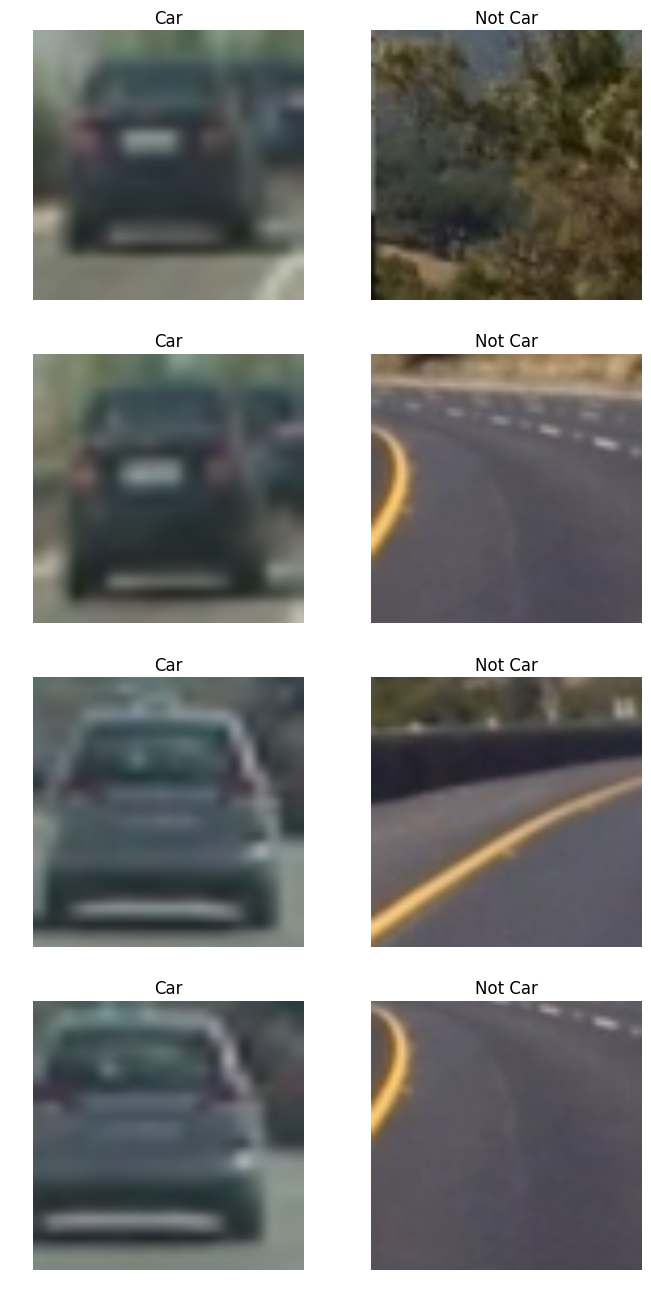

In [6]:
# display some training images

plt_rows = 4
plt_cols = 2
plt.subplots(plt_rows, plt_cols, figsize=(plt_cols*4, plt_rows*4))
for i in range(0, plt_rows * plt_cols):
    plt.subplot(plt_rows, plt_cols, i+1)
    if i % plt_cols < plt_cols/2:
        plt.title('Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(cars[i]))
    else:
        plt.title('Not Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(notcars[i]))
        
print("End of Cell")

End of Cell


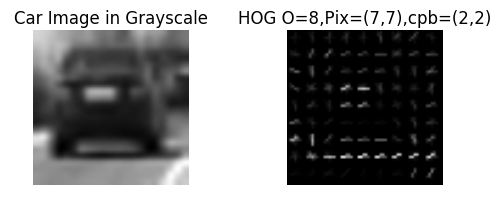

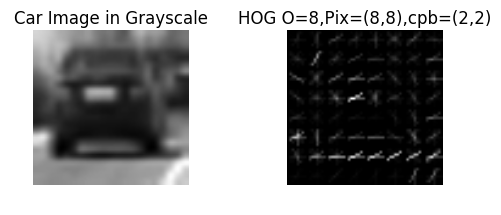

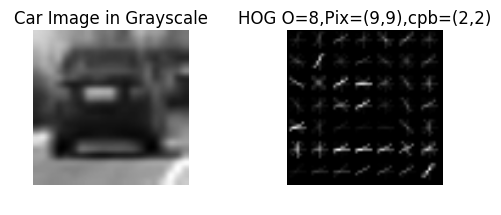

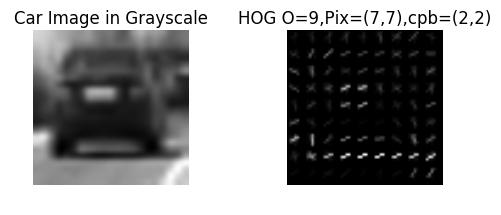

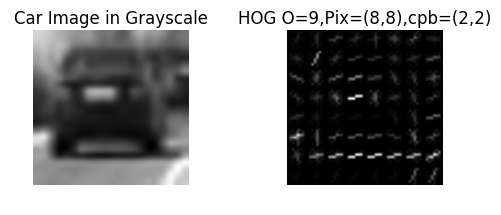

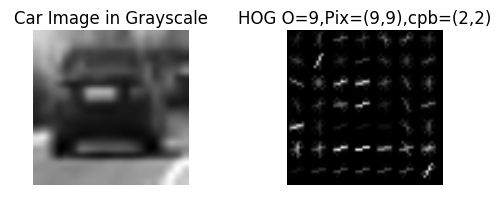

In [7]:
# Explore the effects of the number of orientation bins and the pixels per cell HOG parameters to assess the best candidate

# Read in a random image
car_image = mpimg.imread(cars[0])
notcar_image = mpimg.imread(notcars[0])

# convert to grayscale
car_image_gray = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY) # convert to gray scale

# apply the HOG transform and visualize the resultant image with 6 combinations of orientation bins and pixels per cell
hog_features_1, hog_image_1 = hog(car_image_gray, orientations=8, pixels_per_cell=(7,7), 
                                  cells_per_block=(2,2),visualise=True, feature_vector=False)
hog_features_2, hog_image_2 = hog(car_image_gray, orientations=8, pixels_per_cell=(8,8), 
                                  cells_per_block=(2,2),visualise=True, feature_vector=False)
hog_features_3, hog_image_3 = hog(car_image_gray, orientations=8, pixels_per_cell=(9,9), 
                                  cells_per_block=(2,2),visualise=True, feature_vector=False)
hog_features_4, hog_image_4 = hog(car_image_gray, orientations=9, pixels_per_cell=(7,7), 
                                  cells_per_block=(2,2),visualise=True, feature_vector=False)
hog_features_5, hog_image_5 = hog(car_image_gray, orientations=9, pixels_per_cell=(8,8), 
                                  cells_per_block=(2,2),visualise=True, feature_vector=False)
hog_features_6, hog_image_6 = hog(car_image_gray, orientations=9, pixels_per_cell=(9,9), 
                                  cells_per_block=(2,2),visualise=True, feature_vector=False)

hog_1d = np.ravel(hog_features_1) 

# Plot the original image against its HOG features
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ax1.axis('off')
ax1.set_title('Car Image in Grayscale', fontsize=12)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=8,Pix=(7,7),cpb=(2,2)', fontsize=12)
ax2.imshow(hog_image_1, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ax1.axis('off')
ax1.set_title('Car Image in Grayscale', fontsize=12)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=8,Pix=(8,8),cpb=(2,2)', fontsize=12)
ax2.imshow(hog_image_2, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ax1.axis('off')
ax1.set_title('Car Image in Grayscale', fontsize=12)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=8,Pix=(9,9),cpb=(2,2)', fontsize=12)
ax2.imshow(hog_image_3, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ax1.axis('off')
ax1.set_title('Car Image in Grayscale', fontsize=12)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=9,Pix=(7,7),cpb=(2,2)', fontsize=12)
ax2.imshow(hog_image_4, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ax1.axis('off')
ax1.set_title('Car Image in Grayscale', fontsize=12)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=9,Pix=(8,8),cpb=(2,2)', fontsize=12)
ax2.imshow(hog_image_5, cmap='gray')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))
ax1.axis('off')
ax1.set_title('Car Image in Grayscale', fontsize=12)
ax1.imshow(car_image_gray, cmap='gray')
ax2.axis('off')
ax2.set_title('HOG O=9,Pix=(9,9),cpb=(2,2)', fontsize=12)
ax2.imshow(hog_image_6, cmap='gray')

print("End of Cell")


#### From the images above, it appears that with the number of orientation bins as 9 and with the pixels per cell as (8,8), features are appropriately extracted. The parameters will be used below.

In [8]:
# Extract HOG features from the car and construct a training set and a labelling set

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block

t=time.time()

# extract HOG features of car images
car_features = extract_hog(cars, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)

# extract HOG features of non-car images
notcar_features = extract_hog(notcars, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("End of Cell")

257.23 Seconds to extract features...
End of Cell


In [9]:
# Train the model 

# Split up data into randomized training and test sets in a 8:2 ratio
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Training Classifier')

# declare the linear support vector machine classifer
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
# train the model
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# print the accuracy of the svc on validation data
print('Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

print("End of Cell")

Training Classifier
34.49 Seconds to train SVC...
Accuracy of SVC =  0.9823
End of Cell


End of Cell


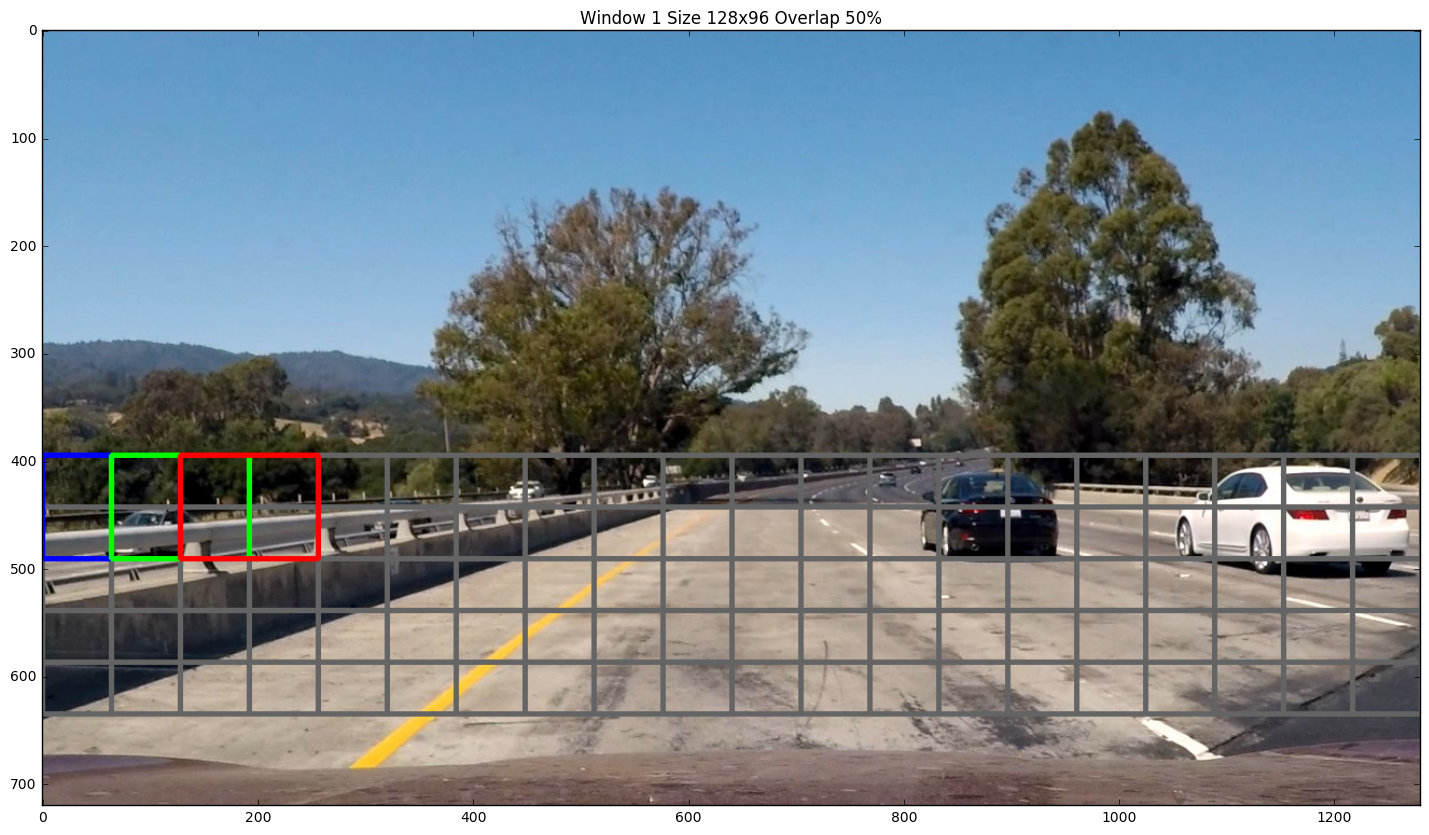

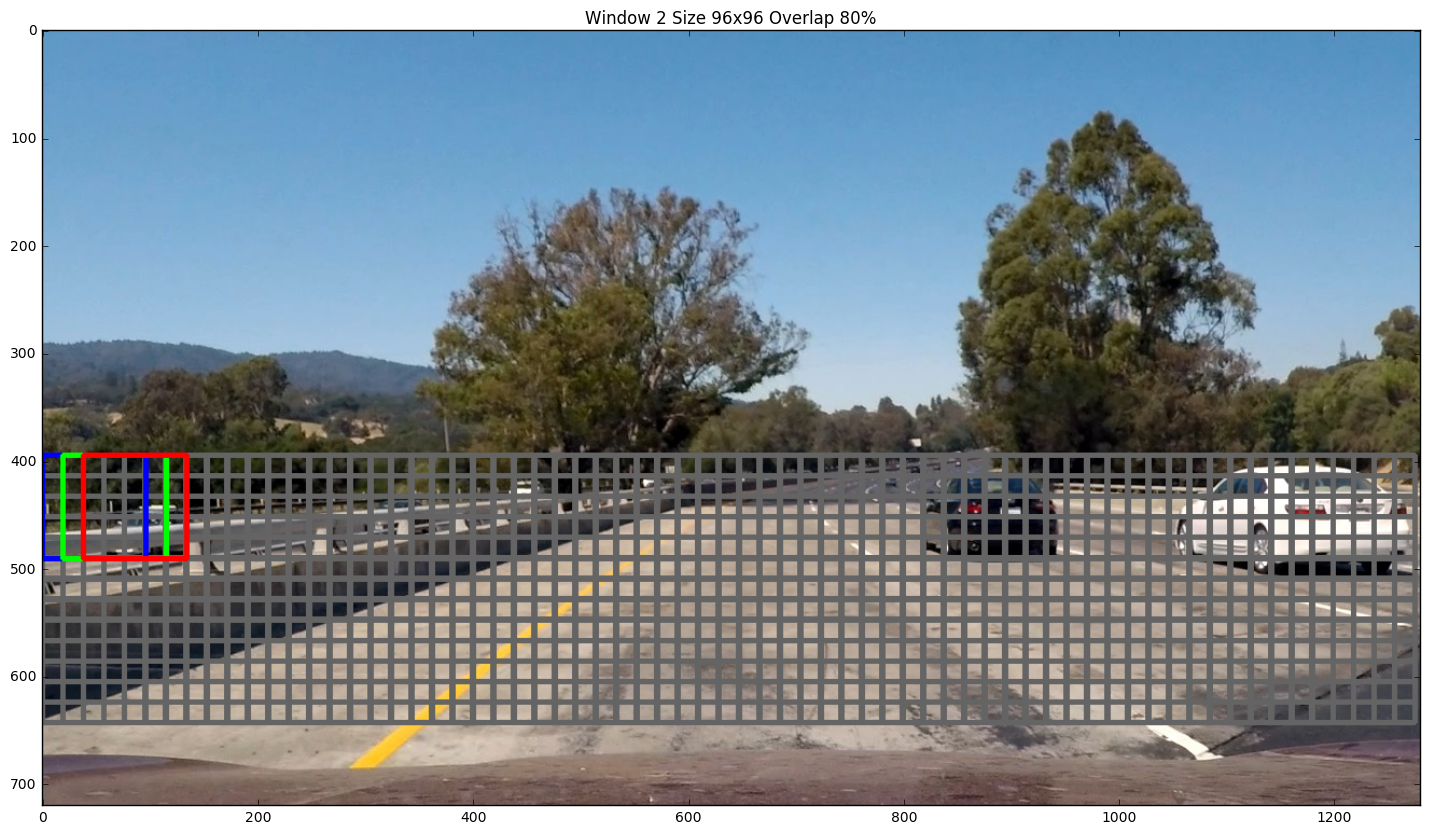

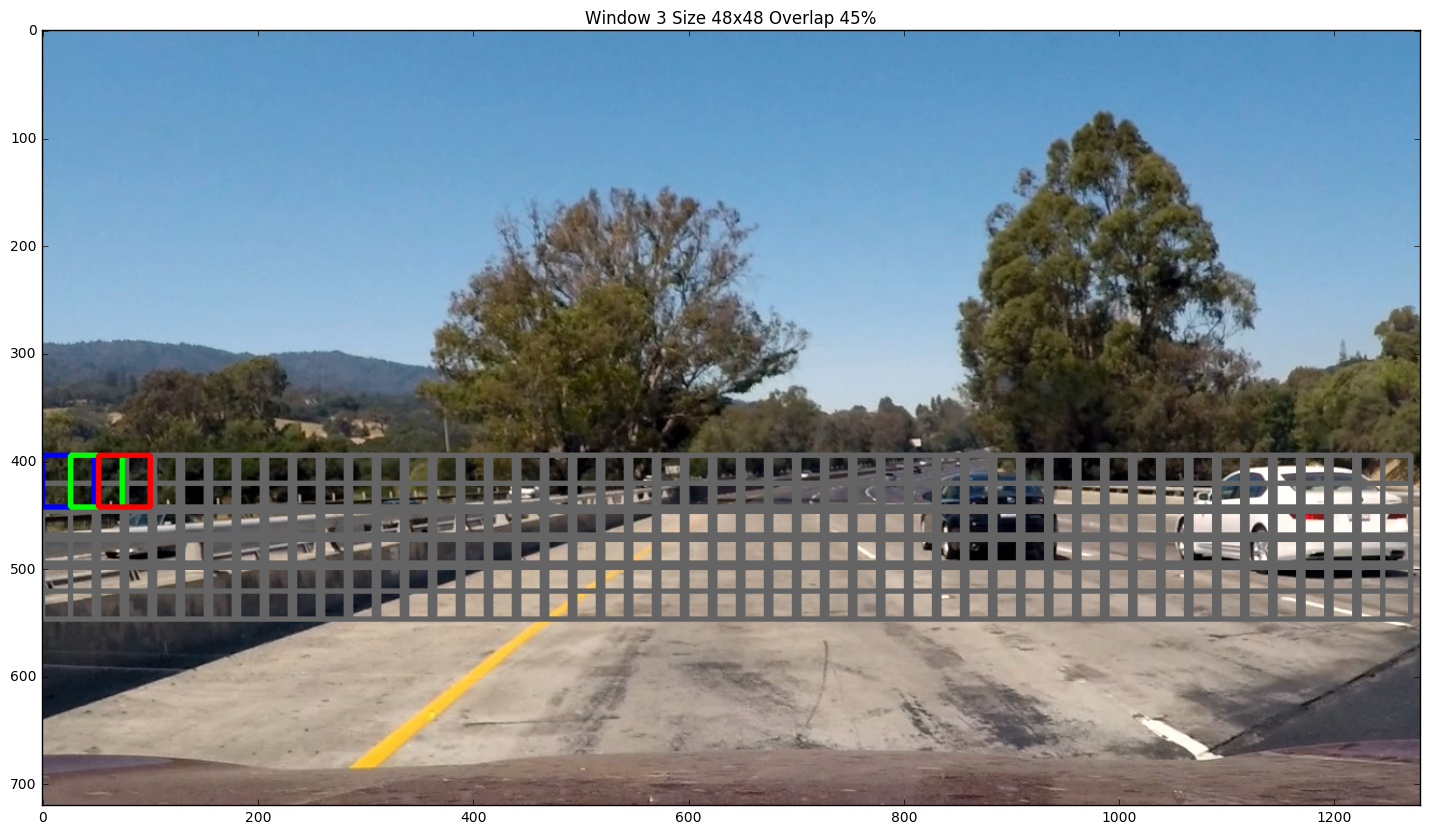

In [14]:
# load test images and display 3 overlapping windows each for all 3 sizes in one testing image
test_images = glob.glob('./test_images/*.jpg')

img = mpimg.imread(test_images[0])
window_img, bboxes, windows1, windows2, windows3 = detect_vehicles(img)

window_img = draw_boxes(img, windows1, color=(0, 0, 255), thick=4)                    
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(window_img)
ax1.set_title("Window 1 Size 128x96 Overlap 50%")

window_img = draw_boxes(img, windows2, color=(0, 0, 255), thick=4)                    
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(window_img)
ax1.set_title("Window 2 Size 96x96 Overlap 80%")

window_img = draw_boxes(img, windows3, color=(0, 0, 255), thick=4)                    
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(window_img)
ax1.set_title("Window 3 Size 48x48 Overlap 45%")

print("End of Cell")

End of Cell


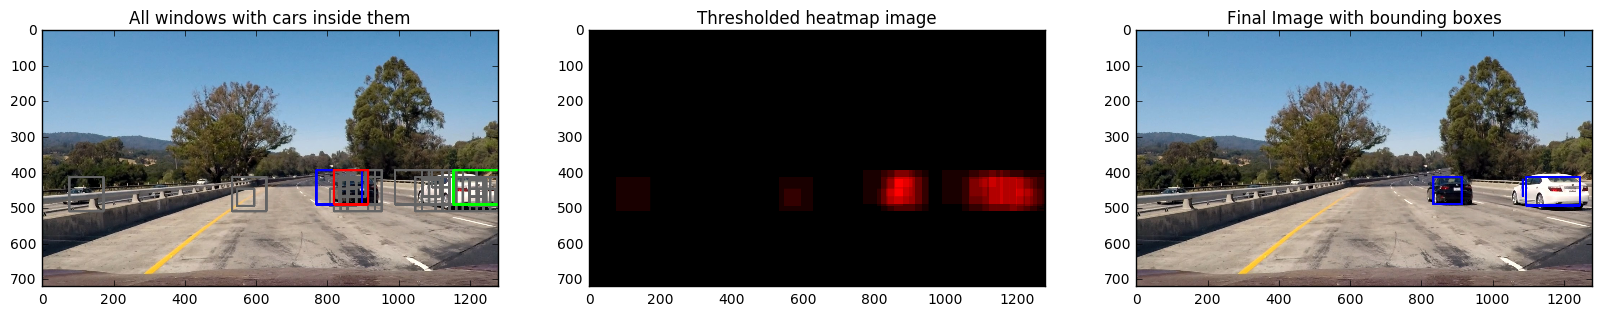

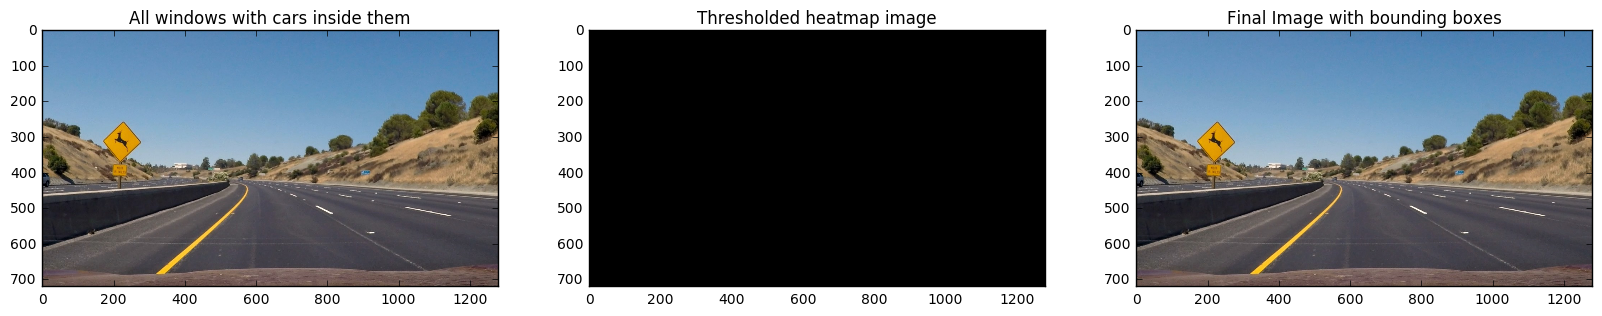

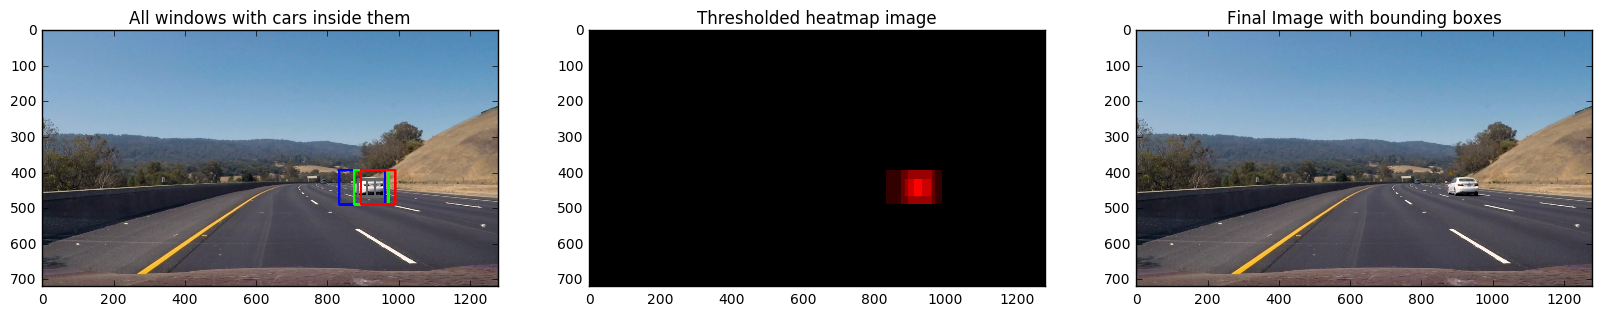

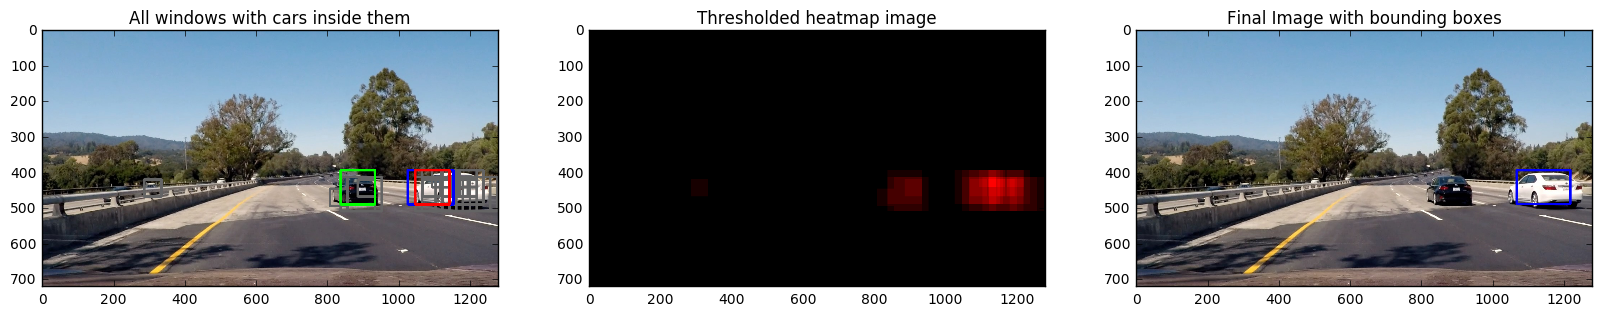

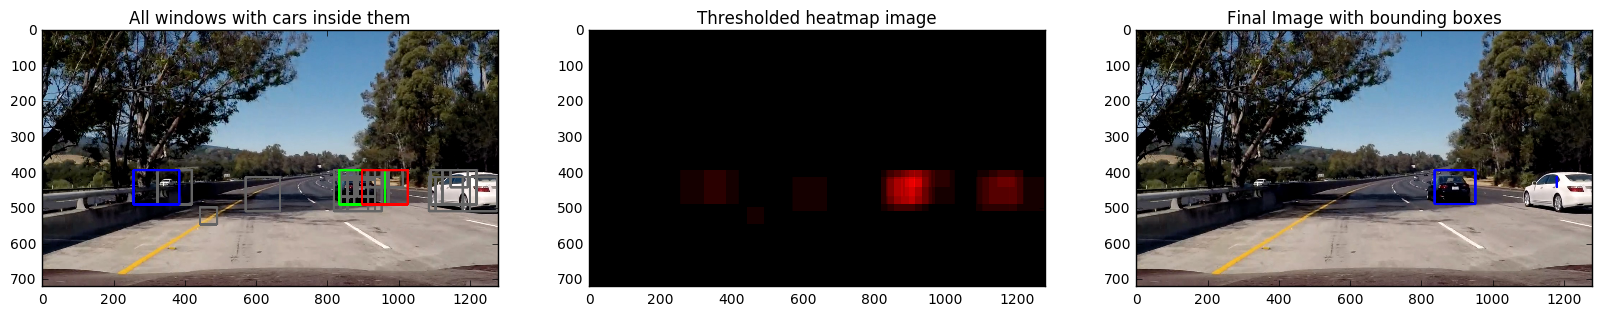

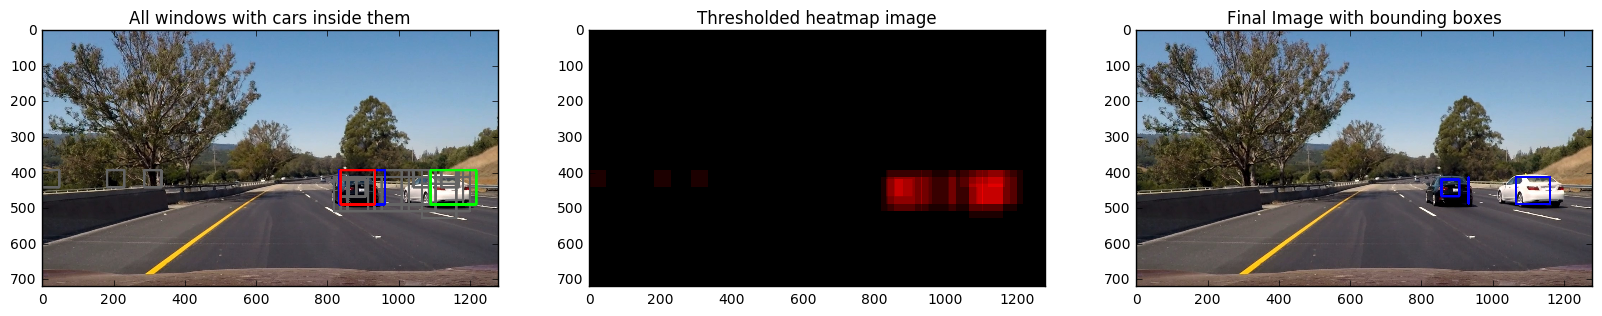

In [11]:
# compute the full pipeline on test images
for testImage in test_images:
    img = mpimg.imread(testImage) # load testing image
    last_bboxes = [] # array to append bounding boxes to
    window_img, bboxes, windows1, windows2, windows3 = detect_vehicles(img) # obtain the list of windows
    last_bboxes.append(bboxes) # append only those windows within which cars were detected
    last_bboxes = last_bboxes[-16:]

    heat = np.zeros_like(img[:,:,0]).astype(np.float) # define an empy array to contain the heat map
    # Add heat to each box in box list
    full_heat = add_heat(heat, [bbox for bboxes in last_bboxes for bbox in bboxes])
    # Apply threshold to help remove false positives
    heat = threshold(full_heat, 5)
    # Visualize the heatmap when displaying    
    full_heatmap = np.clip(full_heat, 0, 255)
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using the label function
    labels = label(heatmap)
    # draw annotated boxes on the image based on the thresholded heatmap
    draw_img = draw_annotated_boxes(np.copy(img), labels)
    
    # visualize the resultant images
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    norm = plt.Normalize(vmin=full_heatmap.min(), vmax=full_heatmap.max())
    norm_heatmap = norm(full_heatmap)
    heatmap_image = (np.dstack((norm_heatmap*255, norm_heatmap, norm_heatmap))).astype(np.uint8)
    ax1.imshow(window_img)
    ax1.set_title("All windows with cars inside them")
    ax2.imshow(heatmap_image)
    ax2.set_title("Thresholded heatmap image")
    ax3.imshow(draw_img)
    ax3.set_title("Final Image with bounding boxes")
    
print("End of Cell")

In [12]:
# process each video frame
def process_frame(image):
    global last_bboxes

    window_img, bboxes, windows1, windows2, windows3 = detect_vehicles(image)

    last_bboxes.append(bboxes)
    last_bboxes = last_bboxes[-16:]
    
    # Read in image similar to one shown above 
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    full_heat = add_heat(heat, [bbox for bboxes in last_bboxes for bbox in bboxes])

    # Apply threshold to help remove false positives
    heat = threshold(full_heat, 15)

    # Visualize the heatmap when displaying    
    full_heatmap = np.clip(full_heat, 0, 255)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_annotated_boxes(np.copy(image), labels)

    return draw_img

print("End of Cell")

End of Cell


In [13]:
print("Starting Video Processing")
last_bboxes = []
t=time.time()
project_output_file = "project_video_out.mp4"
project_video = VideoFileClip("project_video.mp4")

project_output = project_video.fl_image(process_frame)
%time project_output.write_videofile(project_output_file, audio=False)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to process video...')

print("End of Cell")

Starting Video Processing
[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:55:10<00:06,  6.14s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 1h 55min 14s
6925.01 Seconds to process video...
End of Cell
